In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from collections import Counter
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

test['Survived'] = -1

df = pd.concat([train,test])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 132.9+ KB


## Feature engineering

Let's extract some informations in Name and cabin columns to create new features
Vamos extrair mais alguns dados das infromações que a gente já possui, verificando o que pode ser retirado ou melhorado nas colunas de cabine ou nome

### Analyzing Name column

Vamos verificar quais são os textos que a gente possui nos nomes e como podemos utilizá-lo para extrair mais informações

In [5]:
names = df['Name']
print(names)

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object


Já percebemos que existem alguns caracteres especiais no nome, então vamos removê-los e tornar todo o texto minusculo, para que não haja diferença em palavras que são iguais

In [6]:
names_clean = names.apply(lambda x: re.sub(r'[^\w ]+','',x).lower())
print(names_clean)

df['Name'] = names_clean

0                                braund mr owen harris
1      cumings mrs john bradley florence briggs thayer
2                                 heikkinen miss laina
3             futrelle mrs jacques heath lily may peel
4                               allen mr william henry
                            ...                       
413                                   spector mr woolf
414                         oliva y ocana dona fermina
415                         saether mr simon sivertsen
416                                  ware mr frederick
417                             peter master michael j
Name: Name, Length: 1309, dtype: object


Agora que temos o texto sem caracteres e está todo em minusculo, podemos criar um lista com todas as plavras e verificar qual a frequencia de cada palavra

In [7]:
list_names = []
df['Name'].apply(lambda x: list_names.extend(x.split()))

c = Counter(list_names)
print(c.most_common(40))

[('mr', 763), ('miss', 260), ('mrs', 201), ('william', 87), ('john', 72), ('master', 61), ('henry', 49), ('charles', 39), ('james', 38), ('george', 37), ('thomas', 36), ('joseph', 31), ('mary', 30), ('edward', 28), ('elizabeth', 25), ('johan', 22), ('frederick', 21), ('alexander', 20), ('samuel', 20), ('arthur', 20), ('maria', 18), ('anna', 18), ('robert', 18), ('alfred', 18), ('richard', 16), ('margaret', 14), ('albert', 14), ('jr', 14), ('karl', 14), ('frank', 14), ('j', 13), ('peter', 13), ('andersson', 12), ('ernest', 12), ('patrick', 12), ('alice', 12), ('annie', 11), ('h', 11), ('harry', 11), ('sage', 11)]


Vericamos que existem muitos titulos pessoais, os quais podem ser boas features para preencher a idade, que é um campo que possui alguns valores nulos

In [8]:
abrevs = ['mrs','mr','master','miss'] # I put Mrs first to not confuse with Mr when check 

def fill_abrevs(s):
    for abrev in abrevs:
        if abrev in s:
            return abrev
    return 'Normal'

In [9]:
df['Abrev'] = df['Name'].apply(lambda x: fill_abrevs(x))

In [10]:
df['Abrev'].value_counts()

mr        758
miss      258
mrs       201
master     61
Normal     31
Name: Abrev, dtype: int64

Agora que já posuimos a colunas que dispôes os titulos pessoais, podemos verificar se o titulo representa uma média da idade, comprovando se o nosso pensamento é correto 

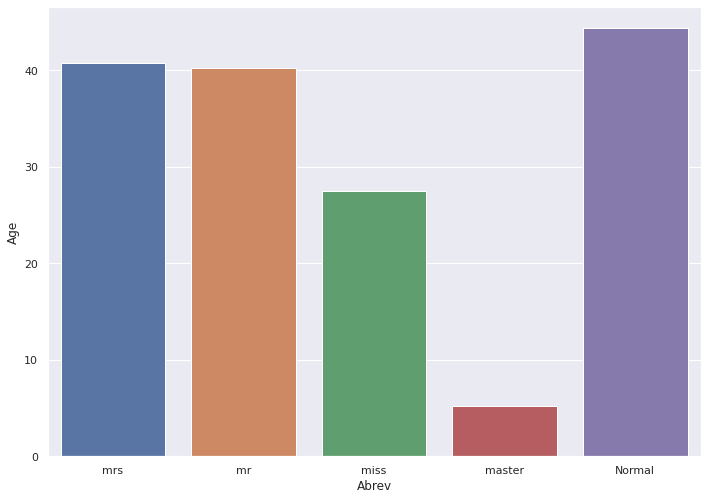

Abrev
Normal    44.357143
master     5.213333
miss      27.518182
mr        40.220833
mrs       40.763889
Name: Age, dtype: float64
{'Normal': 46.0, 'master': 4.0, 'miss': 29.0, 'mr': 39.0, 'mrs': 41.5}


In [11]:
df_not_nan = df.dropna()
sns.barplot(data=df_not_nan,x='Abrev',y='Age', ci=None)
plt.show()

mean_age_abrev = df_not_nan.groupby('Abrev')['Age'].mean()
median_age_abrev = df_not_nan.groupby('Abrev')['Age'].median()
median_age_abrev = median_age_abrev.to_dict()

print(mean_age_abrev)
print(median_age_abrev)

Eu percebi um problema no título master, porém master é um termo para descrever homens menores de idade, então está correto nosso entendimento. Agora que já possuimos o título, podemos inferir a idade das pessoas, então vamos preecher com o mediana do título dado as pessoas.

In [12]:
print(df['Age'].describe())

count    1046.000000
mean       29.881138
std        14.413493
min         0.170000
25%        21.000000
50%        28.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


In [13]:
df['Age'] = df.apply(lambda x: x['Age'] if pd.notna(x['Age']) else median_age_abrev[x['Abrev']], axis=1)
print(df['Age'].describe())

count    1309.000000
mean       31.179656
std        13.519931
min         0.170000
25%        22.000000
50%        30.000000
75%        39.000000
max        80.000000
Name: Age, dtype: float64


### Analyzing Cabin column

In the first rows, we can check that the cabin follows a pattern, let's check that this is real

Nas primeiras linhas das cabines, percebe-se que as cabines seguem um padrão, vamo verificar se isto é verdade

In [14]:
df_not_nan['Cabin'].unique()

array(['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27',
       'D33', 'B30', 'C83', 'F33', 'F G73', 'E31', 'A5', 'D10 D12', 'D26',
       'C110', 'B58 B60', 'E101', 'D47', 'B86', 'F2', 'C2', 'B19', 'A7',
       'C49', 'F4', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'B49',
       'D', 'C22 C26', 'C65', 'E36', 'C54', 'B57 B59 B63 B66', 'C7',
       'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'E33', 'D37',
       'B35', 'E50', 'C82', 'B96 B98', 'E10', 'C52', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'E12', 'E63', 'B37', 'C30', 'D20', 'B79',
       'E25', 'D46', 'B73', 'B38', 'B39', 'B22', 'C86', 'C70', 'A16',
       'C101', 'C68', 'A10', 'E68', 'B41', 'A20', 'D19', 'D50', 'D9',
       'A23', 'B50', 'A26', 'D48', 'E58', 'B71', 'B51 B53 B55', 'D49',
       'B5', 'B20', 'F G63', 'C62 C64', 'E24', 'C90', 'C126', 'C45', 'E8',
       'B101', 'C46', 'D30', 'E121', 'D11', 'E77', 'B3', 'D6', 'B

Não, eles não seguem um padrão, isto faz com que tenhamos problemas ao identificar a letra e o numero da cabine, por isso é interessante criarmos mais três features:

* Uma que descreve a quantidade de cabinas compradas
* Uma que identifica a letra majoritaria das cabines
* Uma que verifica o numero das cabines

No entanto, só possuimos 204 registros das cabines, isto faz com que tenhamos muitos dados faltantes, para isso vamos preencher estas informações e verificar se os dados não preechido equivales ao numero de pessoas que sobreviveram ou não

In [15]:
df['Cabin_amt'] = df['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
df['Cabin_amt'].value_counts()

0    1014
1     254
2      26
3      10
4       5
Name: Cabin_amt, dtype: int64

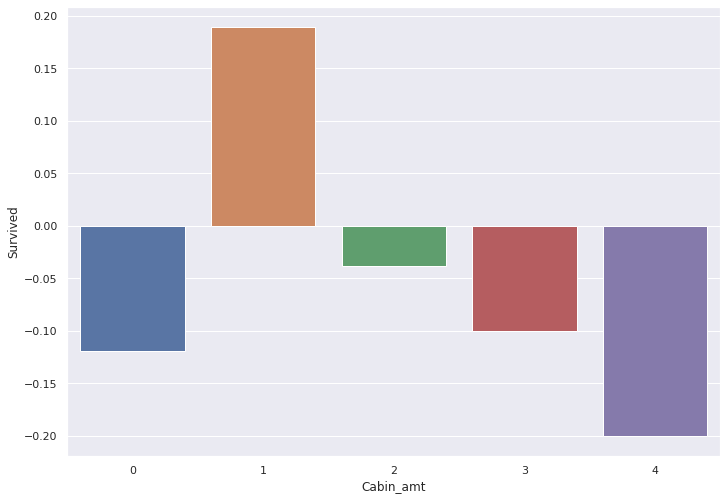

In [16]:
sns.barplot(data=df,y='Survived',x='Cabin_amt', ci=None)
plt.show()

In [17]:
df['Cabin_initial'] = df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'X')
df['Cabin_initial'].value_counts()

X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_initial, dtype: int64

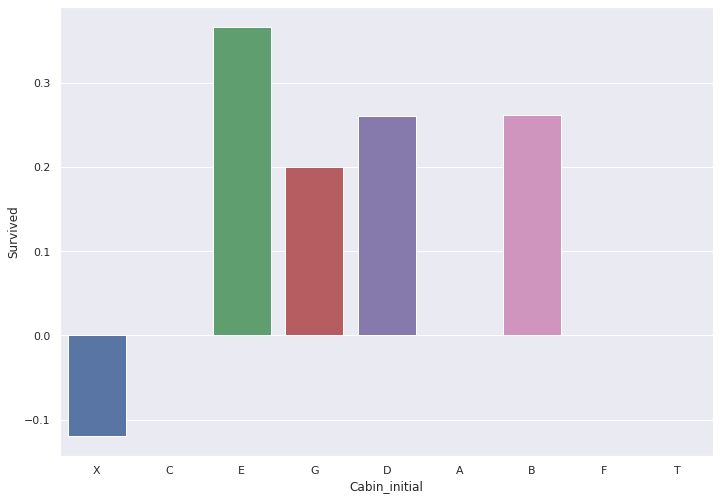

In [18]:
sns.barplot(data=df,y='Survived',x='Cabin_initial', ci=None)
plt.show()

In [19]:
def get_number(cabin):
    if pd.notna(cabin):
        l = re.sub(r'[^\d ]+','',cabin).lower().split()
        if len(l) == 0:
            return 0
        else:
            return int(l[0])
    else:
        return 0

In [20]:
df['Cabin_number'] = df['Cabin'].apply(lambda x: get_number(x))
df['Cabin_number'].describe()

count    1309.000000
mean       10.954163
std        26.050751
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       148.000000
Name: Cabin_number, dtype: float64

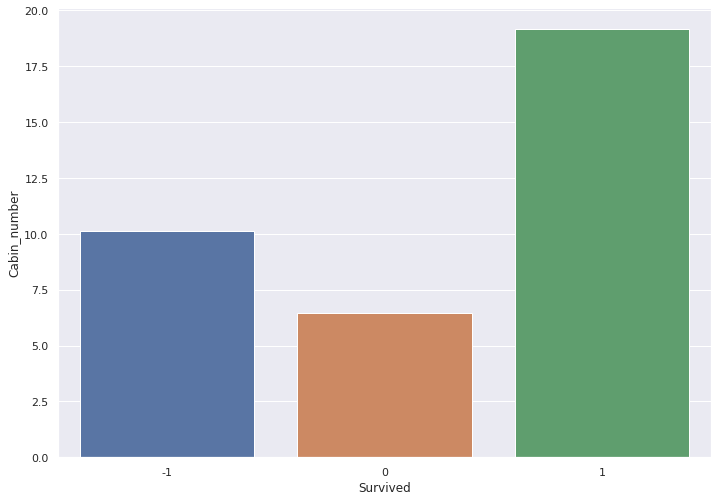

In [21]:
sns.barplot(data=df,x='Survived',y='Cabin_number', ci=None)
plt.show()

Podemos perceber que as features extraídas se relacionam a label 'Survived', isto faz com que tenhamos mais informações para treinarmos nosso modelo de classificação, percebemos também que a maioria das pessoas que não possuem cabine, consequentemente não sobreviveram, é interessante perceber isso pois parece que quanto mais informal é uma pessoa, menos informações ela possui.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       1309 non-null   int64  
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   object 
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1307 non-null   object 
 12  Abrev          1309 non-null   object 
 13  Cabin_amt      1309 non-null   int64  
 14  Cabin_initial  1309 non-null   object 
 15  Cabin_number   1309 non-null   int64  
dtypes: float64(2), int64(7), object(7)
memory usage: 206.1+ KB


Percebemos que ainda temos valores faltantes na coluna 'Cabin', porém não vamos utilizá-la no treinamento, usando apenas suas features

A partir das colunas categóricas, verificamos já duas, 'Cabin' e 'Name', vamos continuar verificando quais informações podem ser extraídas das colunas categoricas que possuimos

### Sex column

In [23]:
print(df['Sex'].unique())

['male' 'female']


Percebe-se que temos corretamente os sexos, vamos convertê-los para binário

In [24]:
sex = {'male':0,'female':1}
df['Sex'] = df['Sex'].apply(lambda x: sex[x])

In [25]:
print(df['Sex'].unique())

[0 1]


### Embarked column

In [26]:
print(df['Embarked'].unique())

['S' 'C' 'Q' nan]


Podemos ver que temos alguns valores nulos, vamos verificar a quantidade para saber se podemos tratar ou não

In [27]:
print(df['Embarked'].isna().sum())

2


Temos apenas 2 valores nulos, quantidade que é indiferente com a quantidade de dados que possuimos, então vamos preencher com o mais presente

In [28]:
df['Embarked'].describe()

count     1307
unique       3
top          S
freq       914
Name: Embarked, dtype: object

In [29]:
df['Embarked'] = df['Embarked'].fillna('S')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       1309 non-null   int64  
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   int64  
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1308 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1309 non-null   object 
 12  Abrev          1309 non-null   object 
 13  Cabin_amt      1309 non-null   int64  
 14  Cabin_initial  1309 non-null   object 
 15  Cabin_number   1309 non-null   int64  
dtypes: float64(2), int64(8), object(6)
memory usage: 206.1+ KB


### Ticket column

In [30]:
print(df['Ticket'].unique())

['A/5 21171' 'PC 17599' 'STON/O2. 3101282' '113803' '373450' '330877'
 '17463' '349909' '347742' '237736' 'PP 9549' '113783' 'A/5. 2151'
 '347082' '350406' '248706' '382652' '244373' '345763' '2649' '239865'
 '248698' '330923' '113788' '347077' '2631' '19950' '330959' '349216'
 'PC 17601' 'PC 17569' '335677' 'C.A. 24579' 'PC 17604' '113789' '2677'
 'A./5. 2152' '345764' '2651' '7546' '11668' '349253' 'SC/Paris 2123'
 '330958' 'S.C./A.4. 23567' '370371' '14311' '2662' '349237' '3101295'
 'A/4. 39886' 'PC 17572' '2926' '113509' '19947' 'C.A. 31026' '2697'
 'C.A. 34651' 'CA 2144' '2669' '113572' '36973' '347088' 'PC 17605' '2661'
 'C.A. 29395' 'S.P. 3464' '3101281' '315151' 'C.A. 33111' 'S.O.C. 14879'
 '2680' '1601' '348123' '349208' '374746' '248738' '364516' '345767'
 '345779' '330932' '113059' 'SO/C 14885' '3101278' 'W./C. 6608'
 'SOTON/OQ 392086' '343275' '343276' '347466' 'W.E.P. 5734' 'C.A. 2315'
 '364500' '374910' 'PC 17754' 'PC 17759' '231919' '244367' '349245'
 '349215' '35281' '

Aqui podemos verificar que o ticket parece que segue o mesmo padrão da cabine, então podemos verificar novamente se estes dados tem alguma relação com o fator de sobrevivência:

* Vamos primeiro identificar o número
* Vamos capturar a informação textual

In [31]:
df['Ticket_number'] = df['Ticket'].apply(lambda x: get_number(x))
df['Ticket_number'].describe()

count    1.309000e+03
mean     2.256340e+05
std      5.064299e+05
min      0.000000e+00
25%      1.176900e+04
50%      3.697300e+04
75%      3.457770e+05
max      3.101317e+06
Name: Ticket_number, dtype: float64

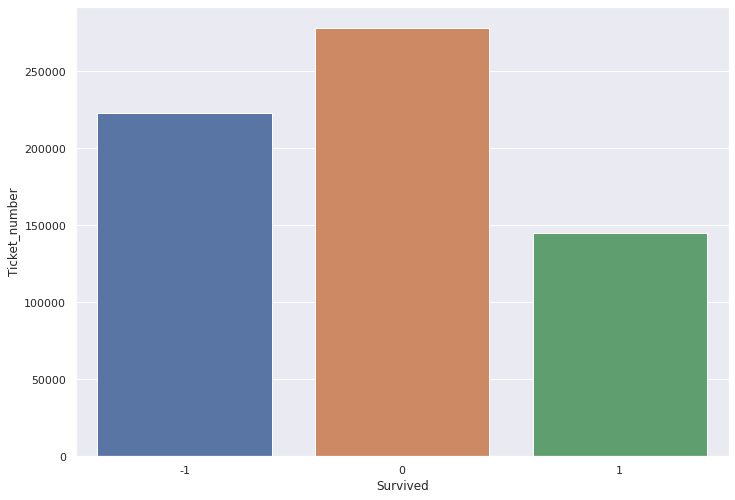

In [32]:
sns.barplot(data=df,x='Survived',y='Ticket_number', ci=None)
plt.show()

In [33]:
df['Ticket_text'] = df['Ticket'].apply(lambda x: x.split()[0] if len(x.split())==2 else 'X')
df['Ticket_text'].value_counts()

X             977
PC             92
C.A.           46
SOTON/O.Q.     16
W./C.          14
A/5            12
CA.            12
SC/PARIS       11
A/5.           10
CA             10
F.C.C.          9
SOTON/OQ        8
C               8
S.O.C.          7
S.O./P.P.       7
STON/O2.        7
A/4             6
SC/Paris        5
SC/AH           4
PP              4
S.C./PARIS      3
F.C.            3
A.5.            3
A/4.            3
A./5.           3
SOTON/O2        3
SC              2
P/PP            2
WE/P            2
W.E.P.          2
C.A./SOTON      1
SC/A.3          1
SC/A4           1
AQ/4            1
LP              1
STON/OQ.        1
Fa              1
S.W./PP         1
A/S             1
SCO/W           1
SW/PP           1
W/C             1
S.O.P.          1
A4.             1
SO/C            1
S.P.            1
S.C./A.4.       1
AQ/3.           1
Name: Ticket_text, dtype: int64

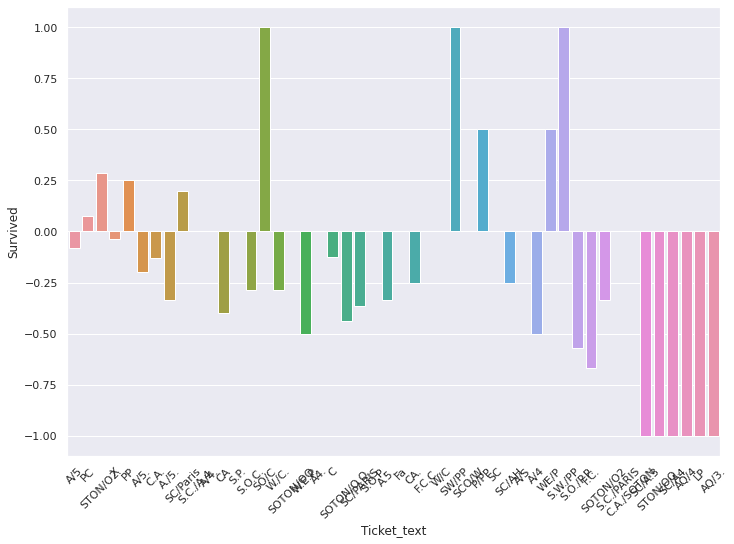

In [34]:
sns.barplot(data=df,y='Survived',x='Ticket_text', ci=None)
plt.xticks(rotation=45)
plt.show()

Claramente podemos verificar que os dados dos ticket se relacionam diretamente com fator de sobrevivência, isso era claro pois o ticket representa bem a classe que a pessoa possuia, a qual interage diretamente com os dados das cabines

## Colunas numéricas

Vamos verificar como a distribuição dos dados numéricos acontence e como podemos lidar com estes valores, primeiramente vamos observar os dados

In [35]:
df_numeric = df.select_dtypes(include='number')

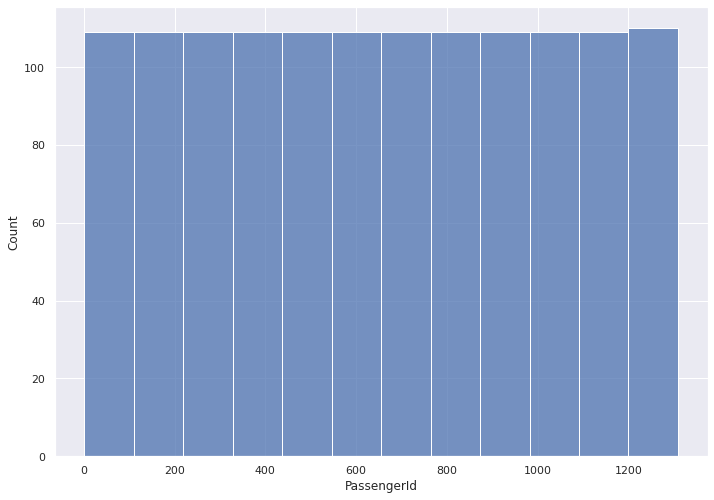

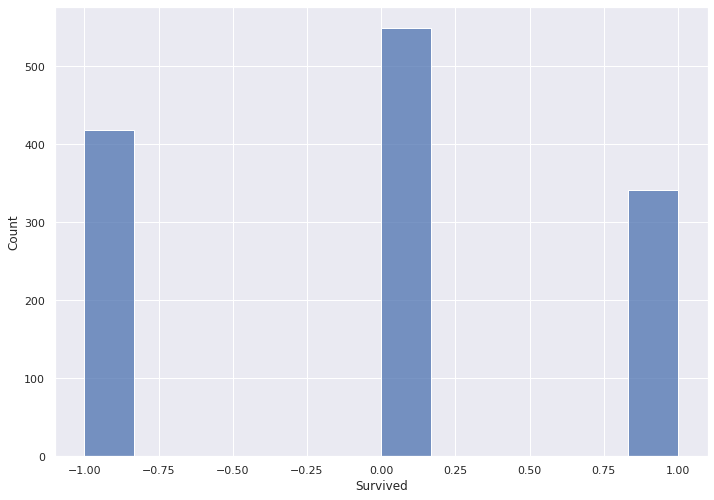

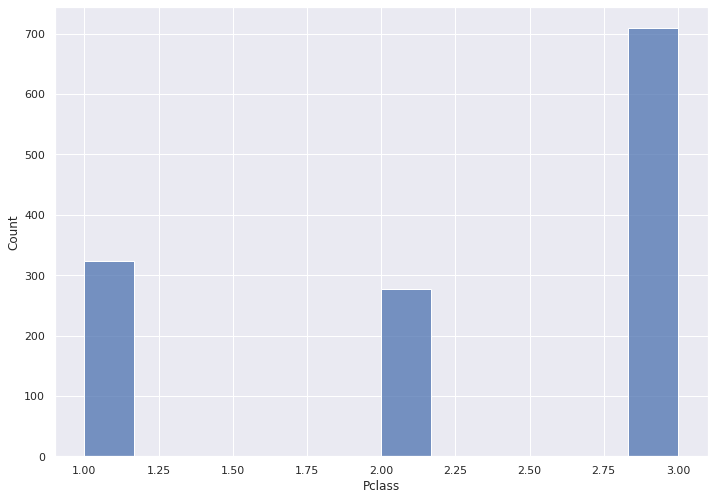

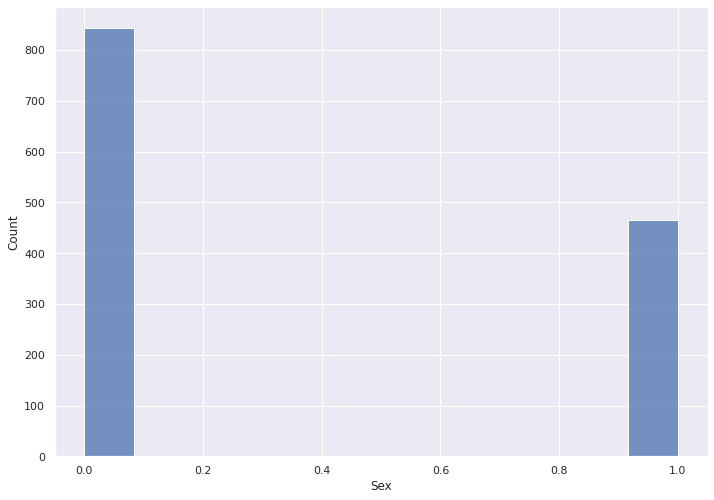

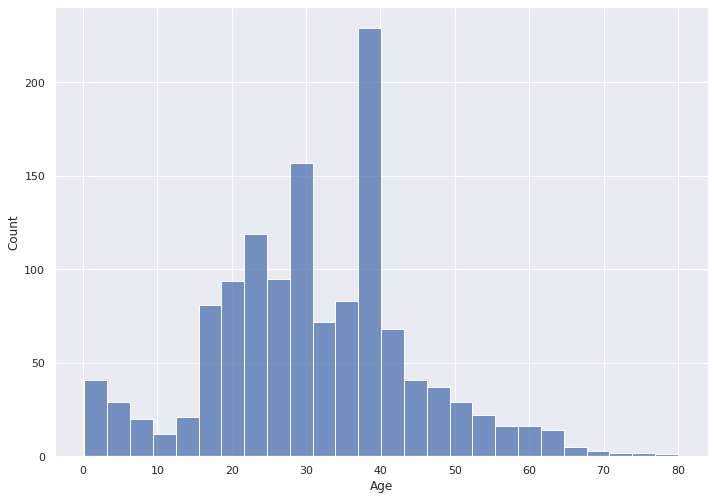

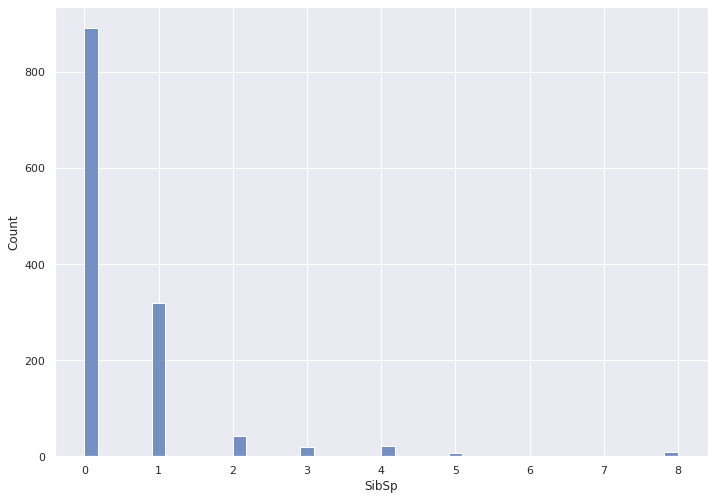

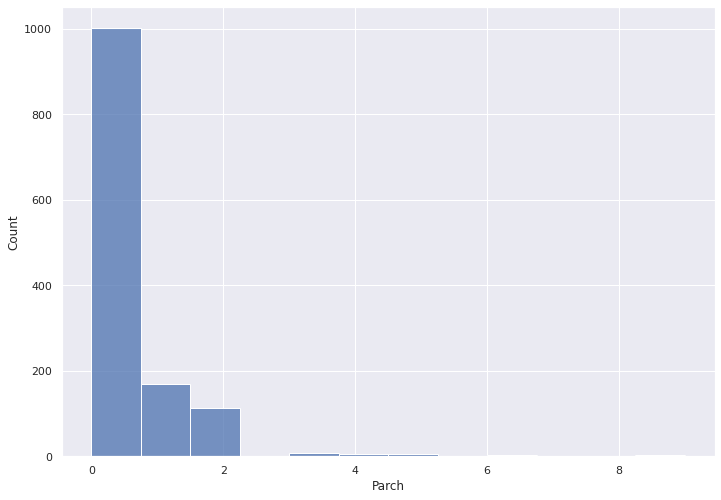

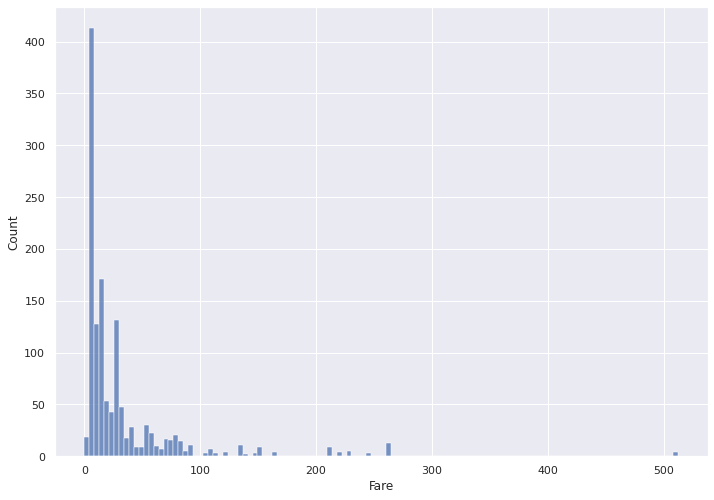

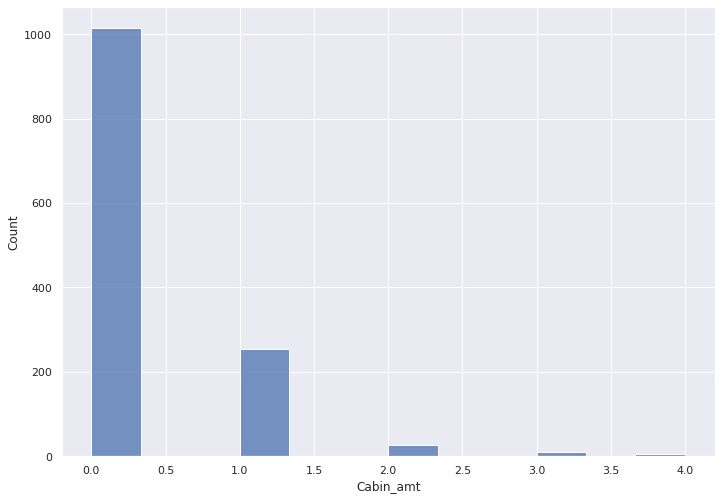

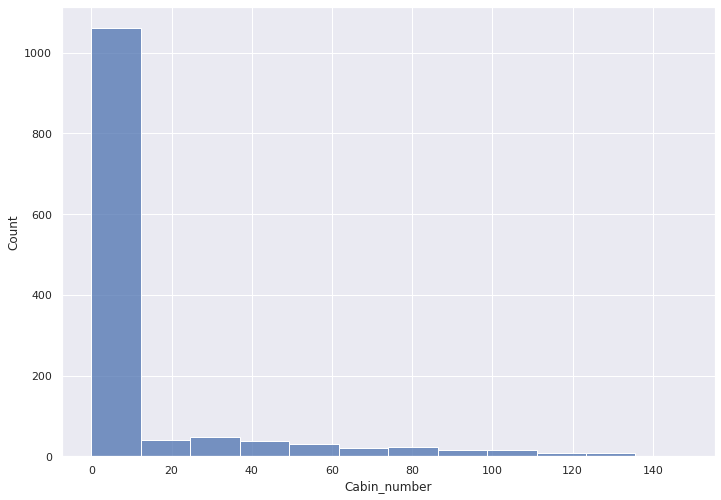

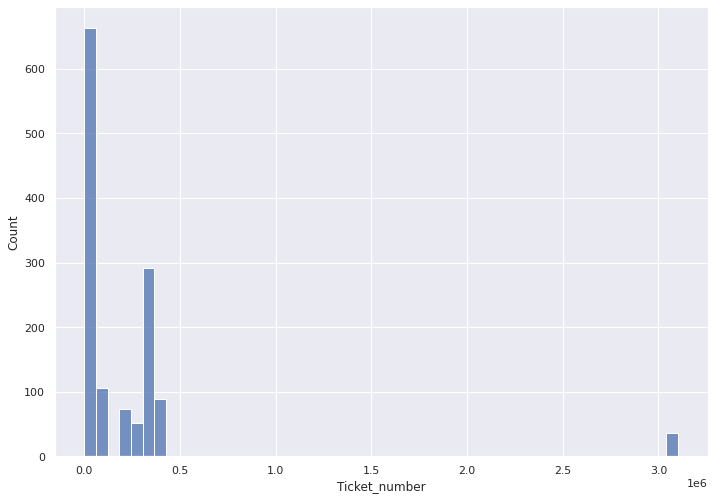

In [36]:
for column in df_numeric:
    sns.histplot(df[column])
    plt.show()

Características de alguns dados são:

* PasengerId é irrelevante no contexto
* Existem mais pessoas que morreram do que as que sobreviveram
* A terceira classe é com a maior amostragem
* Existem mais homens que mulheres na amostragem
* A quantidade de pessoas é majoritariamente menor que 40 anos
* A quantidade é muito maior em relação as pessoas que não tinham parentes, irmãos, pais e filhos
* A maior parcela das pessoas no titanic tinha renda baixa

In [37]:
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

## Manipulação dos dados e teste em diferentes modelos

Além das manipulaçõe feitas anteriormente, vamos verificar como se comparta os modelos com outliers e sem outliers, observando cada aspecto e em qual situação os modelos se compartam de uma maneira melhor

Aqui vamos fazer algumas ações, otimizando este processo para os dados de treinamento:

1. Fazer o encoding das colunas categóricas
2. Dropar as colunas redundantes (As quais foram feitas a engenharia das features)
3. Não vamos adicionar um modelo preditivo ainda, vamos verificar isto posteriomente pois testarei com diferentes modelos

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    1309 non-null   int64  
 1   Survived       1309 non-null   int64  
 2   Pclass         1309 non-null   int64  
 3   Name           1309 non-null   object 
 4   Sex            1309 non-null   int64  
 5   Age            1309 non-null   float64
 6   SibSp          1309 non-null   int64  
 7   Parch          1309 non-null   int64  
 8   Ticket         1309 non-null   object 
 9   Fare           1309 non-null   float64
 10  Cabin          295 non-null    object 
 11  Embarked       1309 non-null   object 
 12  Abrev          1309 non-null   object 
 13  Cabin_amt      1309 non-null   int64  
 14  Cabin_initial  1309 non-null   object 
 15  Cabin_number   1309 non-null   int64  
 16  Ticket_number  1309 non-null   int64  
 17  Ticket_text    1309 non-null   object 
dtypes: float6

In [39]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn import set_config

from sklearn.metrics import classification_report

In [40]:
df_drop = df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

df_dum = pd.get_dummies(df_drop,drop_first=True)
df_dum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 71 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Survived                1309 non-null   int64  
 1   Pclass                  1309 non-null   int64  
 2   Sex                     1309 non-null   int64  
 3   Age                     1309 non-null   float64
 4   SibSp                   1309 non-null   int64  
 5   Parch                   1309 non-null   int64  
 6   Fare                    1309 non-null   float64
 7   Cabin_amt               1309 non-null   int64  
 8   Cabin_number            1309 non-null   int64  
 9   Ticket_number           1309 non-null   int64  
 10  Embarked_Q              1309 non-null   uint8  
 11  Embarked_S              1309 non-null   uint8  
 12  Abrev_master            1309 non-null   uint8  
 13  Abrev_miss              1309 non-null   uint8  
 14  Abrev_mr                1309 non-null   u

In [41]:
train = df_dum[df_dum['Survived']!=-1]
test = df_dum[df_dum['Survived']==-1]

y = train['Survived']
y_test = test['Survived']

X = train.drop(['Survived'],axis=1)
X_test = test.drop(['Survived'],axis=1)

### Split train and test data

In [42]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.30, random_state=42,stratify=y)

In [43]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num_normalizer", Normalizer(), selector(dtype_include=np.number))
    ]
)

In [44]:
RFC = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestClassifier(random_state = 0, n_jobs=-1))]
)

SVM_SVC = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", SVC())]
)

KNC = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", KNeighborsClassifier(n_jobs=-1))]
)

In [45]:
RFC.fit(X_train,y_train)
y_pred_RFC = RFC.predict(X_val)

SVM_SVC.fit(X_train,y_train)
y_pred_SVC = SVM_SVC.predict(X_val)

KNC.fit(X_train,y_train)
y_pred_KNC = KNC.predict(X_val)

In [46]:
RFC_cl = classification_report(y_val,y_pred_RFC)

print('Random Forest Classifier')
print(RFC_cl)

SVC_cl = classification_report(y_val,y_pred_SVC)

print('Support Vector Machine Classifier')
print(SVC_cl)

KNC_cl = classification_report(y_val,y_pred_KNC)

print('K-Neighbors Classifier')
print(KNC_cl)

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       165
           1       0.76      0.73      0.74       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.81      0.81       268

Support Vector Machine Classifier
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       165
           1       0.00      0.00      0.00       103

    accuracy                           0.62       268
   macro avg       0.31      0.50      0.38       268
weighted avg       0.38      0.62      0.47       268

K-Neighbors Classifier
              precision    recall  f1-score   support

           0       0.73      0.78      0.75       165
           1       0.60      0.54      0.57       103

    accuracy                           0.69       268
   macro avg       0.67      0.66      0.66   

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
models = []
models.append(('RFC', RFC))
models.append(('SVC', SVM_SVC))
models.append(('KNC', KNC))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print("%s" %(name))
    msg = "\tMean acc: %f STD: (%f)" % (cv_results.mean(), cv_results.std())
    print(msg)

RFC
	Mean acc: 0.827142 STD: (0.021859)
SVC
	Mean acc: 0.616163 STD: (0.002325)
KNC
	Mean acc: 0.692493 STD: (0.018373)


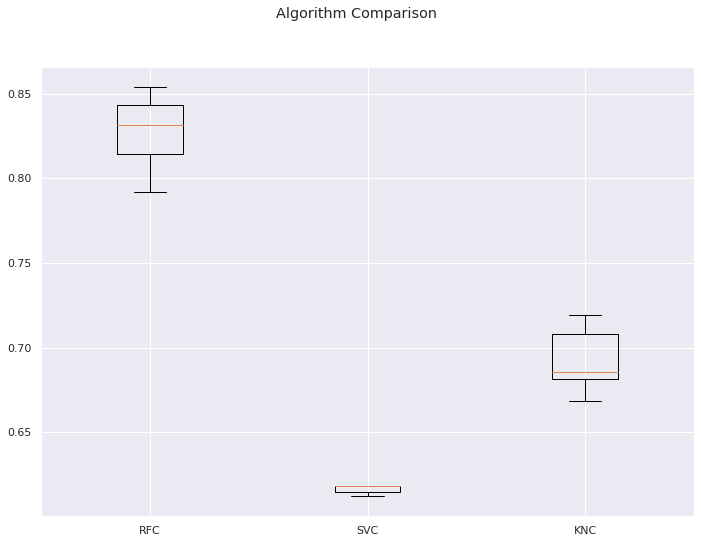

In [48]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [49]:
y_pred = RFC.predict(X_test)

In [50]:
test = pd.read_csv('../input/titanic/test.csv')
test['Survived'] = y_pred

In [51]:
test[['PassengerId','Survived']].to_csv('./gender_sub_v1.csv',index=False)